In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
# From https://docs.vllm.ai/en/latest/automatic_prefix_caching/apc.html
LONG_PROMPT = "You are a helpful assistant in recognizes the content of tables in markdown format. Here is a table as follows.\n# Table\n" + """
| ID  | Name          | Age | Occupation    | Country       | Email                  | Phone Number   | Address                       |
|-----|---------------|-----|---------------|---------------|------------------------|----------------|------------------------------|
| 1   | John Doe      | 29  | Engineer      | USA           | john.doe@example.com   | 555-1234       | 123 Elm St, Springfield, IL  |
| 2   | Jane Smith    | 34  | Doctor        | Canada        | jane.smith@example.com | 555-5678       | 456 Oak St, Toronto, ON      |
| 3   | Alice Johnson | 27  | Teacher       | UK            | alice.j@example.com    | 555-8765       | 789 Pine St, London, UK      |
| 4   | Bob Brown     | 45  | Artist        | Australia     | bob.b@example.com      | 555-4321       | 321 Maple St, Sydney, NSW    |
| 5   | Carol White   | 31  | Scientist     | New Zealand   | carol.w@example.com    | 555-6789       | 654 Birch St, Wellington, NZ |
| 6   | Dave Green    | 28  | Lawyer        | Ireland       | dave.g@example.com     | 555-3456       | 987 Cedar St, Dublin, IE     |
| 7   | Emma Black    | 40  | Musician      | USA           | emma.b@example.com     | 555-1111       | 246 Ash St, New York, NY     |
| 8   | Frank Blue    | 37  | Chef          | Canada        | frank.b@example.com    | 555-2222       | 135 Spruce St, Vancouver, BC |
| 9   | Grace Yellow  | 50  | Engineer      | UK            | grace.y@example.com    | 555-3333       | 864 Fir St, Manchester, UK   |
| 10  | Henry Violet  | 32  | Artist        | Australia     | henry.v@example.com    | 555-4444       | 753 Willow St, Melbourne, VIC|
| 11  | Irene Orange  | 26  | Scientist     | New Zealand   | irene.o@example.com    | 555-5555       | 912 Poplar St, Auckland, NZ  |
| 12  | Jack Indigo   | 38  | Teacher       | Ireland       | jack.i@example.com     | 555-6666       | 159 Elm St, Cork, IE         |
| 13  | Karen Red     | 41  | Lawyer        | USA           | karen.r@example.com    | 555-7777       | 357 Cedar St, Boston, MA     |
| 14  | Leo Brown     | 30  | Chef          | Canada        | leo.b@example.com      | 555-8888       | 246 Oak St, Calgary, AB      |
| 15  | Mia Green     | 33  | Musician      | UK            | mia.g@example.com      | 555-9999       | 975 Pine St, Edinburgh, UK   |
| 16  | Noah Yellow   | 29  | Doctor        | Australia     | noah.y@example.com     | 555-0000       | 864 Birch St, Brisbane, QLD  |
| 17  | Olivia Blue   | 35  | Engineer      | New Zealand   | olivia.b@example.com   | 555-1212       | 753 Maple St, Hamilton, NZ   |
| 18  | Peter Black   | 42  | Artist        | Ireland       | peter.b@example.com    | 555-3434       | 912 Fir St, Limerick, IE     |
| 19  | Quinn White   | 28  | Scientist     | USA           | quinn.w@example.com    | 555-5656       | 159 Willow St, Seattle, WA   |
| 20  | Rachel Red    | 31  | Teacher       | Canada        | rachel.r@example.com   | 555-7878       | 357 Poplar St, Ottawa, ON    |
| 21  | Steve Green   | 44  | Lawyer        | UK            | steve.g@example.com    | 555-9090       | 753 Elm St, Birmingham, UK   |
| 22  | Tina Blue     | 36  | Musician      | Australia     | tina.b@example.com     | 555-1213       | 864 Cedar St, Perth, WA      |
| 23  | Umar Black    | 39  | Chef          | New Zealand   | umar.b@example.com     | 555-3435       | 975 Spruce St, Christchurch, NZ|
| 24  | Victor Yellow | 43  | Engineer      | Ireland       | victor.y@example.com   | 555-5657       | 246 Willow St, Galway, IE    |
| 25  | Wendy Orange  | 27  | Artist        | USA           | wendy.o@example.com    | 555-7879       | 135 Elm St, Denver, CO       |
| 26  | Xavier Green  | 34  | Scientist     | Canada        | xavier.g@example.com   | 555-9091       | 357 Oak St, Montreal, QC     |
| 27  | Yara Red      | 41  | Teacher       | UK            | yara.r@example.com     | 555-1214       | 975 Pine St, Leeds, UK       |
| 28  | Zack Blue     | 30  | Lawyer        | Australia     | zack.b@example.com     | 555-3436       | 135 Birch St, Adelaide, SA   |
| 29  | Amy White     | 33  | Musician      | New Zealand   | amy.w@example.com      | 555-5658       | 159 Maple St, Wellington, NZ |
| 30  | Ben Black     | 38  | Chef          | Ireland       | ben.b@example.com      | 555-7870       | 246 Fir St, Waterford, IE    |
"""

In [3]:
import asyncio
from tqdm.notebook import tqdm
from arsenal.timer import Timer
from viztracer import VizTracer
from async_llm.llm import AsyncLLM

In [4]:
from util import token_prefixes
text = (
    "Question: what is the age of John Doe? Your answer: The age of John Doe is 39. "
    "Question: what is the age of Zach Blue? Your answer: The age of Zach Blue is 30."
    "Question: what is the occupation of Jane Smith? Your answer: Jane Smith is a Doctor. "
    "Question: what is the country of Alice Johnson? Your answer: Alice Johnson is from the UK. "
    "Question: what is the email of Bob Brown? Your answer: Bob Brown's email is bob.b@example.com. "
    "Question: what is the phone number of Carol White? Your answer: Carol White's phone number is 555-6789. "
    "Question: what is the address of Dave Green? Your answer: Dave Green's address is 987 Cedar St, Dublin, IE. "
    "Question: what is the age of Emma Black? Your answer: Emma Black is 40 years old. "
    "Question: what is the occupation of Frank Blue? Your answer: Frank Blue is a Chef. "
    "Question: what is the country of Grace Yellow? Your answer: Grace Yellow is from the UK."
)

In [5]:
model_name = 'lmsys/longchat-13b-16k'

noncached_llm = AsyncLLM.from_name(
    model_name, engine_opts={'gpu_memory_utilization' : 0.9, 'enable_prefix_caching' : False}
)

INFO 12-20 22:48:51 config.py:478] This model supports multiple tasks: {'embed', 'generate', 'score', 'classify', 'reward'}. Defaulting to 'generate'.
INFO 12-20 22:48:51 llm_engine.py:249] Initializing an LLM engine (v0.6.5) with config: model='lmsys/longchat-13b-16k', speculative_config=None, tokenizer='lmsys/longchat-13b-16k', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=16384, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=lmsys/longchat-13b-16k, 

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

INFO 12-20 22:48:56 selector.py:120] Using Flash Attention backend.
INFO 12-20 22:48:57 model_runner.py:1092] Starting to load model lmsys/longchat-13b-16k...
INFO 12-20 22:48:57 weight_utils.py:243] Using model weights format ['*.bin']


Loading pt checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


/home/mila/b/benjamin.lebrun/scratch/async-llm/lib/python3.10/site-packages/vllm/model_executor/model_loader/weight_utils.py:425: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

INFO 12-20 22:49:41 model_runner.py:1097] Loading model weights took 24.2869 GB
INFO 12-20 22:49:44 worker.py:241] Memory profiling takes 3.30 seconds
INFO 12-20 22:49:44 worker.py:241] the current vLLM instance can use total_gpu_memory (79.44GiB) x gpu_memory_utilization (0.90) = 71.49GiB
INFO 12-20 22:49:44 worker.py:241] model weights take 24.29GiB; non_torch_memory takes 0.12GiB; PyTorch activation peak memory takes 1.74GiB; the rest of the memory reserved for KV Cache is 45.34GiB.
INFO 12-20 22:49:44 gpu_executor.py:76] # GPU blocks: 3714, # CPU blocks: 327
INFO 12-20 22:49:44 gpu_executor.py:80] Maximum concurrency for 16384 tokens per request: 3.63x
INFO 12-20 22:49:47 model_runner.py:1413] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-20 22:49:47 model_runner.py:1417] If out-of-memory error occurs during cudagraph captur

In [6]:
prefixes = token_prefixes(text, noncached_llm.tokenizer, LONG_PROMPT)

noncached_timer = Timer('noncached_llm')

for token_ids in tqdm(prefixes):
    with noncached_timer(len=len(token_ids)):
        await noncached_llm.next_token_logprobs(token_ids)

0it [00:00, ?it/s]

INFO 12-20 22:50:10 metrics.py:467] Avg prompt throughput: 732.4 tokens/s, Avg generation throughput: 0.4 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 12-20 22:50:15 metrics.py:467] Avg prompt throughput: 8998.9 tokens/s, Avg generation throughput: 4.9 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 12-20 22:50:20 metrics.py:467] Avg prompt throughput: 8752.0 tokens/s, Avg generation throughput: 4.7 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 12-20 22:50:25 metrics.py:467] Avg prompt throughput: 8825.3 tokens/s, Avg generation throughput: 4.6 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 12-20 22:50:30 metrics.py:467] Avg prompt throughput: 8801.4 tokens/s, Avg generation throughput: 4.6 tokens/s, Runn

In [7]:
del noncached_llm

In [8]:
cached_llm = AsyncLLM.from_name(
    model_name, engine_opts={'gpu_memory_utilization' : 0.9, 'enable_prefix_caching' : True} 
)

INFO 12-20 22:51:08 config.py:478] This model supports multiple tasks: {'embed', 'generate', 'score', 'classify', 'reward'}. Defaulting to 'generate'.
INFO 12-20 22:51:08 llm_engine.py:249] Initializing an LLM engine (v0.6.5) with config: model='lmsys/longchat-13b-16k', speculative_config=None, tokenizer='lmsys/longchat-13b-16k', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=16384, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=lmsys/longchat-13b-16k, 

Task was destroyed but it is pending!
task: <Task pending name='Task-3' coro=<AsyncLLMEngine.run_engine_loop() running at /home/mila/b/benjamin.lebrun/scratch/async-llm/lib/python3.10/site-packages/vllm/engine/async_llm_engine.py:867> wait_for=<Future pending cb=[Task.__wakeup()]> cb=[_log_task_completion(error_callback=<bound method...7f89a1f8da80>>)() at /home/mila/b/benjamin.lebrun/scratch/async-llm/lib/python3.10/site-packages/vllm/engine/async_llm_engine.py:48, shield.<locals>._inner_done_callback() at /home/mila/b/benjamin.lebrun/scratch/async-llm/lib/python3.10/asyncio/tasks.py:847]>


INFO 12-20 22:51:09 model_runner.py:1092] Starting to load model lmsys/longchat-13b-16k...
INFO 12-20 22:51:10 weight_utils.py:243] Using model weights format ['*.bin']


Loading pt checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


INFO 12-20 22:51:50 model_runner.py:1097] Loading model weights took 24.2830 GB
INFO 12-20 22:51:52 worker.py:241] Memory profiling takes 1.89 seconds
INFO 12-20 22:51:52 worker.py:241] the current vLLM instance can use total_gpu_memory (79.44GiB) x gpu_memory_utilization (0.90) = 71.49GiB
INFO 12-20 22:51:52 worker.py:241] model weights take 24.28GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 1.73GiB; the rest of the memory reserved for KV Cache is 45.47GiB.
INFO 12-20 22:51:52 gpu_executor.py:76] # GPU blocks: 3724, # CPU blocks: 327
INFO 12-20 22:51:52 gpu_executor.py:80] Maximum concurrency for 16384 tokens per request: 3.64x
INFO 12-20 22:51:53 model_runner.py:1413] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 12-20 22:51:53 model_runner.py:1417] If out-of-memory error occurs during cudagraph captur

In [9]:
prefixes = token_prefixes(text, cached_llm.tokenizer, LONG_PROMPT)

cached_timer = Timer('cached_llm')

for token_ids in tqdm(prefixes):
    with cached_timer(len=len(token_ids)):
        await cached_llm.next_token_logprobs(token_ids)

0it [00:00, ?it/s]

INFO 12-20 22:52:17 metrics.py:467] Avg prompt throughput: 313.5 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 12-20 22:52:17 metrics.py:483] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO 12-20 22:52:22 metrics.py:467] Avg prompt throughput: 79196.9 tokens/s, Avg generation throughput: 40.8 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 12-20 22:52:22 metrics.py:483] Prefix cache hit rate: GPU: 99.49%, CPU: 0.00%


In [10]:
del cached_llm

In [11]:
cached_timer.compare(noncached_timer)

cached_llm is 9.4817x faster than noncached_llm (p=0.00000, median: noncached_llm: 0.222042, cached_llm: 0.0234179)


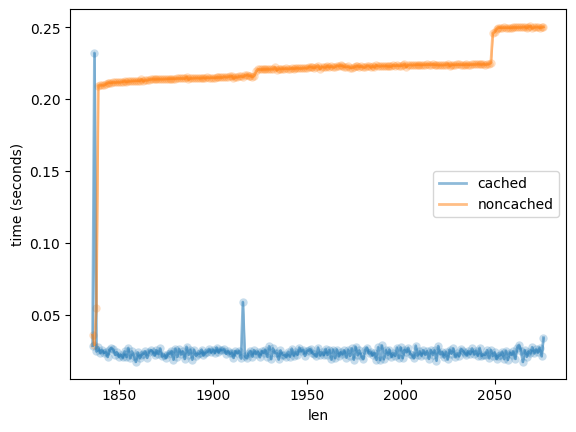

In [12]:
ax = cached_timer.plot_feature('len', label='cached')
ax = noncached_timer.plot_feature('len', ax=ax, label='noncached')
ax.legend()